In [10]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
# add root folder to path
sys.path.append('../../')
from training.data.datasets import load_json_data
import seaborn as sns

/home/getzner/miniconda3/envs/tandic-experiments/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading
## Raw Data (used for annotation)

In [14]:
with open("results/data_used_for_annotation_with_chatgpt.jsonl") as f:
    raw_data = [json.loads(line) for line in f]
raw_data = pd.DataFrame(raw_data)
print(raw_data.shape)
raw_data.head()

(1974, 6)


,id,title,text,category,climate_scanner,old_id
0,0,The Shattering Truth of 3D-Printed Clothing,When the fashion trio threeASFOUR debuted its ...,3d_printed_apparel,True,0
1,1,Soon you may be able to 3D print clothing in y...,Three-dimensional printing has changed the way...,3d_printed_apparel,True,1
2,2,A clothing startup founded by MIT grads is usi...,The Insider Picks team writes about stuff we t...,3d_printed_apparel,True,4
3,3,3D Printing of Clothing,3D Printing of Clothing\nThe technology behind...,3d_printed_apparel,True,5
4,4,3D printed fashion: Why is additive manufactur...,3D printed fashion: Why is additive manufactur...,3d_printed_apparel,True,6


## Predictions / Annotations

In [19]:
# load predictions.jsonl from current folder
with open("results/predictions.jsonl") as f:
    preds = [json.loads(line) for line in f]
preds = {list(p.keys())[0]:p[list(p.keys())[0]] for p in preds}
new_rows = []
for article_id, section_predictions in preds.items():
    for section_pred in section_predictions:
        new_row = {
            "article_id": article_id,
            "article_id (old)": raw_data.iloc[int(article_id)]["old_id"],
            "section_id": section_pred["section_id"],
            "section_category": section_pred["category"],
            "article_level_category": raw_data.iloc[int(article_id)]["category"],
            "text": section_pred["text"],
            "reasoning": section_pred["reasoning"],
            "explanation": section_pred["explanation"],
        }
        new_rows.append(new_row)
predictions = pd.DataFrame(new_rows)
predictions.shape

(44272, 8)

# Analysis of results
## Label Distribution

In [17]:
# count samples per label
predictions.section_category.value_counts()

section_category
sustainable_agriculture_production    3602
none                                  3443
smart_collaboration_tools             1497
unsure                                1401
carbon_price                          1340
                                      ... 
sustainable_energy                       3
electric_vehicles                        2
sustainable_energy_production            2
autonomous transport                     1
virtual_reality_travel_experiences       1
Name: count, Length: 78, dtype: int64

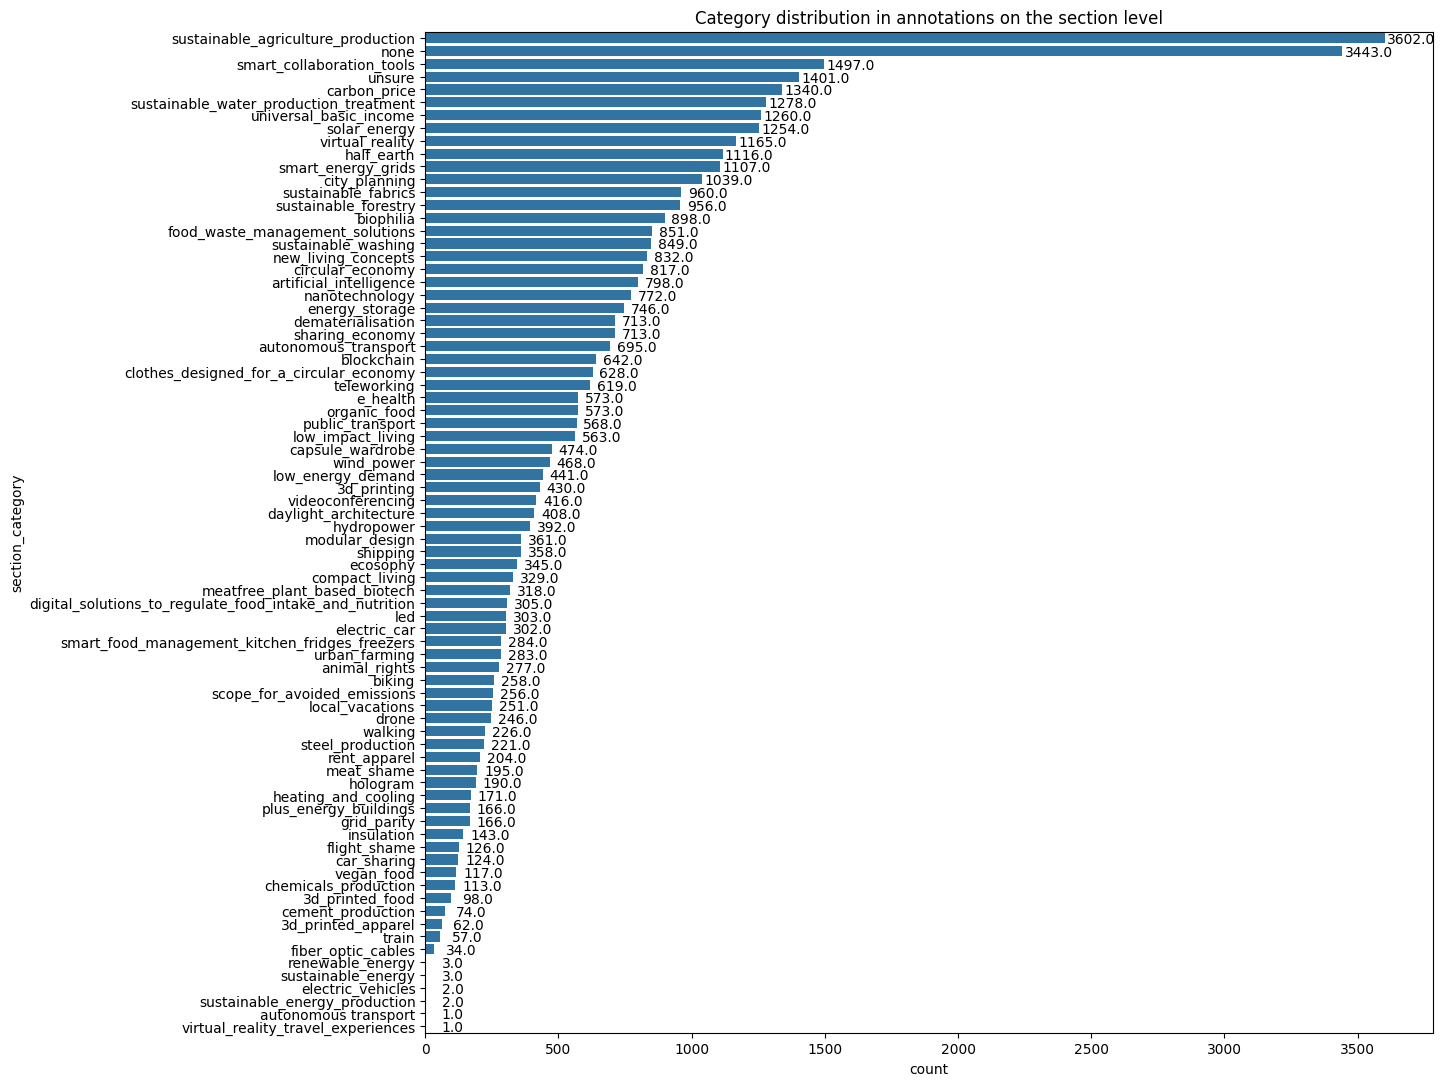

In [26]:
plt.figure(figsize=(13, 13))
ax = sns.countplot(y="section_category", data=predictions, order=predictions.section_category.value_counts().index)
plt.title("Category distribution in annotations on the section level")

# Add numbers to the bars
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{width}', (width + 100, p.get_y() + 0.5), ha='center', va='center')
plt.show()


Text(0.5, 1.0, 'Category distribution on the article level in raw data')

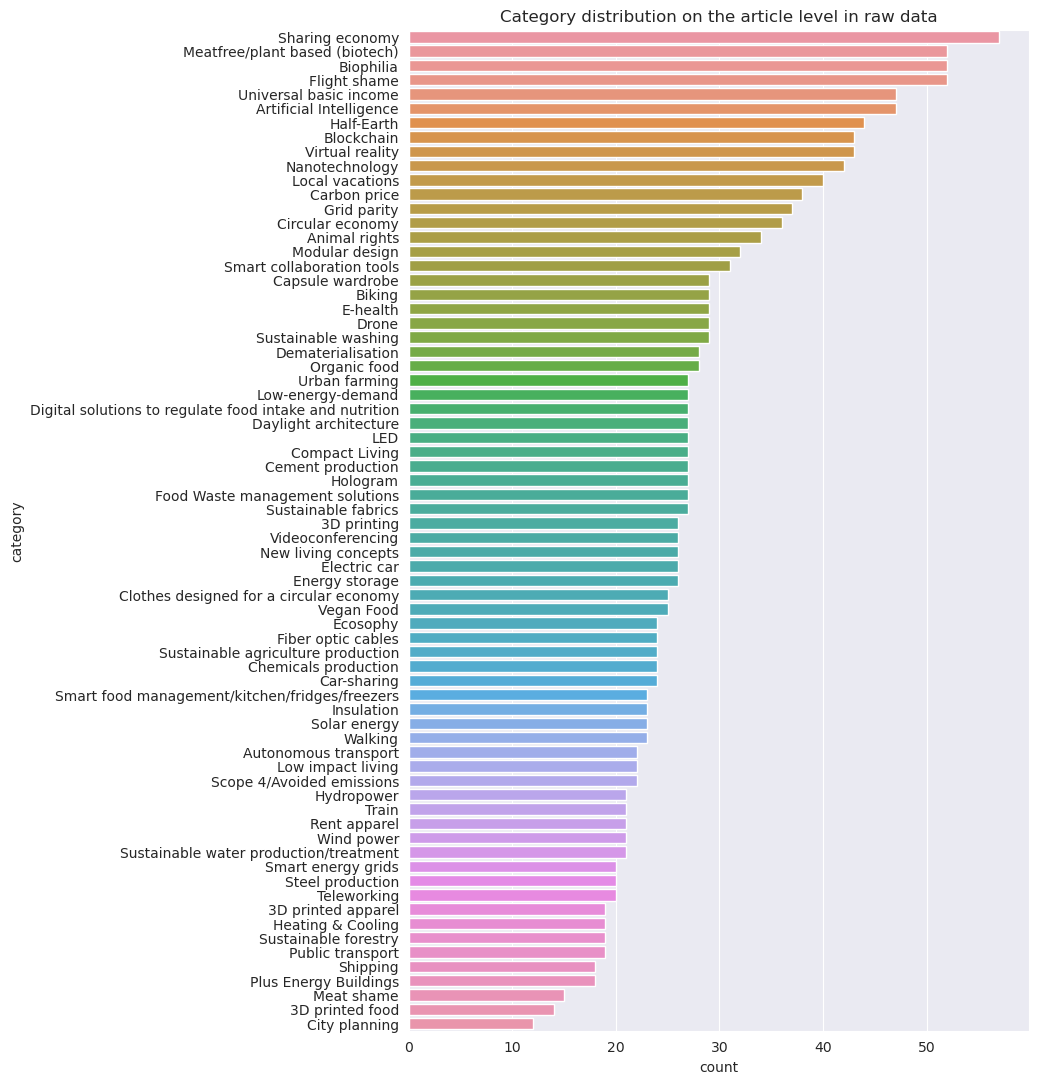

In [ ]:
plt.figure(figsize=(8, 13))
sns.countplot(y="category", data=raw_data, order = raw_data.category.value_counts().index)
plt.title("Category distribution on the article level in raw data")

## Inspect "unsure" and "none" labels

In [ ]:
predictions.loc[predictions.section_category.isin(["none","unsure"])]

,article_id,section_id,section_category,article_level_category,reasoning,explanation
32,2,12,none,3D printed apparel,The section does not provide specific details ...,{'1': {'prediction_1': {'category': '3d_printe...
103,6,9,none,3D printed apparel,The article segment does not explicitly mentio...,{'0': {'prediction_1': {'category': '3d_printi...
147,11,4,none,3D printed apparel,The section does not contain any specific info...,{'0': {'prediction_1': {'category': '3d_printe...
196,16,4,none,3D printed apparel,The section does not provide specific informat...,{'0': {'prediction_1': {'category': 'sustainab...
209,16,17,none,3D printed apparel,The section does not specifically mention any ...,{'1': {'prediction_1': {'category': 'clothes_d...
...,...,...,...,...,...,...
1810,48,144,unsure,Autonomous transport,The section discusses autonomous driving in th...,{'1': {'prediction_1': {'category': 'autonomou...
1821,48,155,unsure,Autonomous transport,The section contains references to academic co...,"{'1': {'prediction_1': {'category': 'unsure', ..."
1842,48,176,none,Autonomous transport,The article segment does not focus on autonomo...,{'1': {'prediction_1': {'category': 'autonomou...
1844,48,178,none,Autonomous transport,The section is specifically focused on the pol...,{'1': {'prediction_1': {'category': 'autonomou...


In [ ]:
from IPython.display import Markdown
row = predictions.iloc[1355]
print(f"----- Article {row.article_id} - Section {row.section_id}")
print(f"----- Title: {raw_data.iloc[int(row.article_id)]['title']}")
print(f"----- Final category: {row.section_category}, because: {row.reasoning}")
for annotator_id, conversation in row.explanation.items():
    print(f"\nAnnotator #{annotator_id}")
    for idx, (msg_type, msg) in enumerate(conversation.items()):
        if msg_type.startswith("prediction"):
            print(f"{'-'*(idx+1)} Chosen category: {msg['category']}")
            print(f"{'-'*(idx+1)} Reasoning: {msg['reasoning']}")
        else:
            print(f"{'-'*(idx+1)} The evaluator responded and claimed the annotation as '{msg['conclusion']}'.")
            print(f"{'-'*(idx+1)} Their reasoning: {msg['reasoning']}")

----- Article 37 - Section 181
----- Title: The Influence of 3D Printing on Global Container Multimodal Transport System
----- Final category: unsure, because: The article section discusses the impact of 3D printing on the global container multimodal transport system and specifically mentions the transportation of printing filaments and finished products. It does not explicitly refer to autonomous transport, and the focus on cargo transportation and its impact on different stages of the transportation chain may not align directly with autonomous transport. Therefore, I believe that the 'unsure' category is the most appropriate choice for this section, as the content does not clearly fit into the category of autonomous transport.

Annotator #0
- Chosen category: autonomous_transport
- Reasoning: The section discusses the impact of 3D printing on the global container multimodal transport system, focusing on the transportation of printing filaments and finished products. This aligns with 

# Save data

In [ ]:
# get old already annotated data
old_data = load_json_data("../../training/datasets")
old_data = old_data.rename(columns={"sentence_id": "section_id"})

In [ ]:
final_dataset = []
for idx, row in predictions.iterrows():
    if row["article_id (old)"] in set(old_data.article_id.values):
        # human annotation already exists, skip
        continue
    article_id = int(row.article_id)
    section_id = row.section_id
    label = row.section_category
    text = ""
    spans = []
    new_row = {
        "article_id": article_id,
        "section_id": section_id,
        "label": label,
        "text": text,
        "spans": spans
    }
    final_dataset.append(new_row)
final_dataset = pd.DataFrame(final_dataset)
print(final_dataset.shape)
final_dataset.head()

(1105, 5)


,article_id,section_id,label,text,spans
0,7,0,3d_printing,,[]
1,7,1,3d_printed_apparel,,[]
2,10,0,3d_printing,,[]
3,19,0,circular_economy,,[]
4,19,1,3d_printing,,[]


In [ ]:
final_dataset = pd.concat([old_data, final_dataset])
final_dataset.head()

,text,label,spans,article_id,section_id,article_id (old)
0,J Sol. Energy Eng. April 2018; 140(2): 021012....,fiber_optic_cables,[fiber-optic],424,8,424.0
1,Energy Eng. April 2018; 140(2): 021012. https:...,fiber_optic_cables,[fiber-optic],424,9,424.0
2,April 2018; 140(2): 021012. https://doi.org/10...,fiber_optic_cables,[fiber-optic],424,10,424.0
3,"The scope included the design, development, an...",fiber_optic_cables,[fiber-optic cables],424,11,424.0
4,The designed system is comprised of two subsys...,fiber_optic_cables,"[fiber-optic cables, fiber-optic cables]",424,12,424.0


In [ ]:
# save dataset to parquet
final_dataset.to_parquet("final_dataset.parquet")